In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random

df = pd.read_csv("/Users/vedikagoyal/Desktop/python_jn/covtype.csv")  # Download from UCI/Kaggle

print("Dataset Shape:", df.shape)
print(df.head())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (581012, 55)
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2      

In [9]:
#Cover Type Mapping
cover_type_mapping = {
    1: "Spruce/Fir",
    2: "Lodgepole Pine",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
}

In [10]:
# Separate Features & Target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Scale continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [11]:
#Train Random Forest Model
# ----------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print("\nRandom Forest Accuracy:", rf_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 0.9555261051780074

Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.94      0.95     42557
           2       0.95      0.97      0.96     56500
           3       0.95      0.97      0.95      7121
           4       0.92      0.85      0.88       526
           5       0.95      0.77      0.85      1995
           6       0.93      0.90      0.92      3489
           7       0.97      0.95      0.96      4015

    accuracy                           0.96    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.96      0.96      0.96    116203



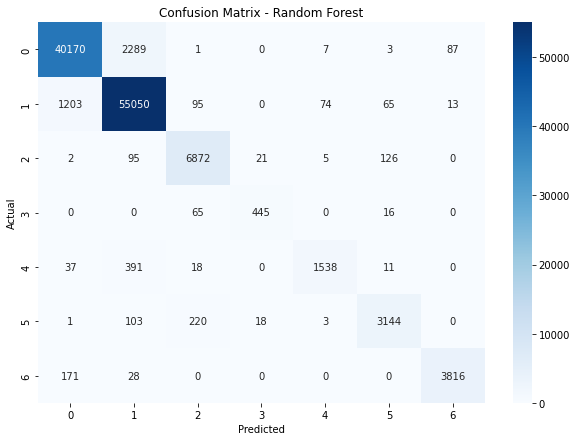

In [12]:
#Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

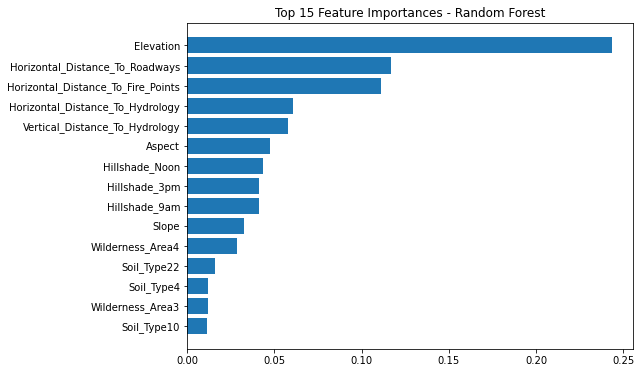

In [13]:
# Feature Importance Plot
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), np.array(X.columns)[indices])
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

In [15]:
#Single Sample Prediction (Readable Output)
sample_index = np.random.randint(0, X_test.shape[0])
sample_features = X_test[sample_index].reshape(1, -1)
sample_actual_code = y_test.iloc[sample_index]
sample_actual_name = cover_type_mapping[sample_actual_code]

sample_pred_code = rf.predict(sample_features)[0]
sample_pred_name = cover_type_mapping[sample_pred_code]

print("\nSingle Sample Prediction Check")
print(f"Predicted Cover Type: {sample_pred_code} - {sample_pred_name}")
print(f"Actual Cover Type:    {sample_actual_code} - {sample_actual_name}")



Single Sample Prediction Check
Predicted Cover Type: 2 - Lodgepole Pine
Actual Cover Type:    2 - Lodgepole Pine


In [16]:
#Multiple Predictions Table (5 Random Samples)
sample_indices = random.sample(range(X_test.shape[0]), 5)

results = []
for idx in sample_indices:
    pred_code = rf.predict(X_test[idx].reshape(1, -1))[0]
    pred_name = cover_type_mapping[pred_code]
    actual_code = y_test.iloc[idx]
    actual_name = cover_type_mapping[actual_code]
    results.append({
        "Predicted Code": pred_code,
        "Predicted Name": pred_name,
        "Actual Code": actual_code,
        "Actual Name": actual_name
    })

results_df = pd.DataFrame(results)
print("\n5 Random Predictions vs Actual Values:\n")
print(results_df)


5 Random Predictions vs Actual Values:

   Predicted Code  Predicted Name  Actual Code     Actual Name
0               1      Spruce/Fir            1      Spruce/Fir
1               1      Spruce/Fir            1      Spruce/Fir
2               2  Lodgepole Pine            2  Lodgepole Pine
3               1      Spruce/Fir            1      Spruce/Fir
4               7       Krummholz            7       Krummholz



 XGBoost Accuracy: 0.8711823274786366

 Classification Report - XGB:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85     42557
           2       0.87      0.90      0.88     56500
           3       0.90      0.91      0.91      7121
           4       0.91      0.86      0.89       526
           5       0.89      0.59      0.71      1995
           6       0.85      0.82      0.83      3489
           7       0.94      0.92      0.93      4015

    accuracy                           0.87    116203
   macro avg       0.89      0.83      0.86    116203
weighted avg       0.87      0.87      0.87    116203



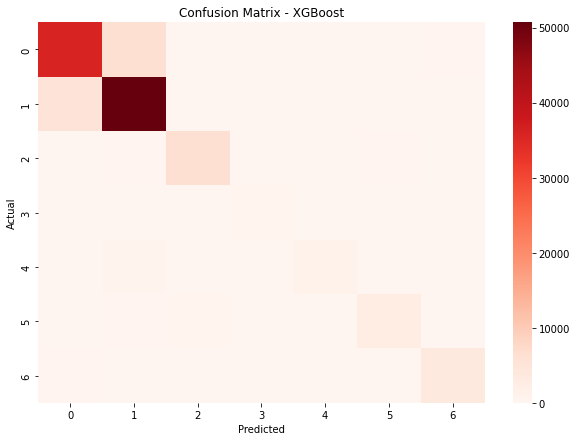


Model Accuracy Comparison:
            Model  Accuracy
0  Random Forest  0.955526
1        XGBoost  0.871182


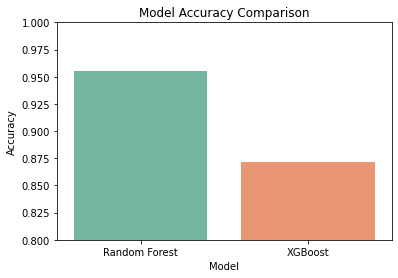

In [19]:
#XGBoost Model (Compare with RF)
import xgboost as xgb

y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=7,
                              eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train_xgb)

y_pred_xgb = xgb_model.predict(X_test) + 1

# Accuracy
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print("\n XGBoost Accuracy:", xgb_acc)
print("\n Classification Report - XGB:\n", classification_report(y_test, y_pred_xgb))

#Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=False, cmap='Reds')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy Comparison Table
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [rf_acc, xgb_acc]
})
print("\nModel Accuracy Comparison:\n", results_df)

plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="Set2")
plt.ylim(0.8, 1.0)
plt.title("Model Accuracy Comparison")
plt.show()
